In [1]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )

    ! pip install geopandas
    ! pip install zipfile
    ! pip install us
    ! pip install netcdf4
    ! pip install progressbar

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

# load needed scientific libraries
from functools import partial
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, deque
from itertools import chain
import requests
import zipfile
import io
import us
import time
from progressbar import ProgressBar

# turn off warnings
import warnings

warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import network_dl
import nhd_network_utilities_v02 as nnu


In [2]:
#####################################################################################
# Load and mask network data - Cape Fear River Basin, North Carolina
#####################################################################################
# Create directory path variable for test/input/geo, where NHD data and masks are stored
test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")

# Load network meta data for the Cape Fear Basin
supernetwork = "CapeFear_FULL_RES"
network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# if the NHDPlus RouteLink file does not exist, download it.
if not os.path.exists(network_data["geo_file_path"]):
    filename = os.path.basename(network_data["geo_file_path"])
    network_dl.download(network_data["geo_file_path"], network_data["data_link"])

# read-in NHD data, retain a copy for viz purposes
data = nhd_io.read(network_data["geo_file_path"])
dat_geo = data.copy()

# select only the necessary columns needed for network analysis and computation
cols = [v for c, v in network_data.items() if c.endswith("_col")]
data = data[cols]

# set the Data Frame index (row labels) to the key column - "featureID"
data = data.set_index(network_data["key_col"])
dat_geo = dat_geo.set_index(network_data["key_col"])

# mask NHDNetwork to isolate test network - full resolution Cape Fear basin, NC
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"], layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)
    dat_geo = dat_geo.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort data by index
data = data.sort_index()

print("NHD data loaded and masked")


NHD data loaded and masked


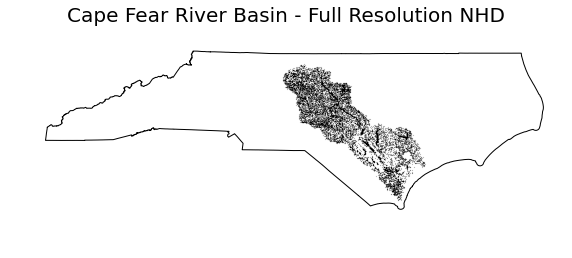

In [3]:
#####################################################################################
# Visualize the Cape Fear basin
#####################################################################################

# create a pandas GeoDataFrame for viz purposes
gdf = gpd.GeoDataFrame(dat_geo, geometry=gpd.points_from_xy(dat_geo.lon, dat_geo.lat))

################################################
# Download North Carolina shapefile for basemap
################################################
shape_url = us.states.NC.shapefile_urls()["state"]
local_path = "../test/input/geo/NorthCarolina_state_shape"

# Download and extract shapefile
r = requests.get(shape_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)

# get extracted filenames
filenames = [
    y
    for y in sorted(z.namelist())
    for ending in ["dbf", "prj", "shp", "shx"]
    if y.endswith(ending)
]
dbf, prj, shp, shx = [filename for filename in filenames]

# load shapefile with GeoPandas
nc = gpd.read_file(local_path + "/" + shp)

################################################
# Create a map
################################################

# create a basemap
base = nc.plot(color="white", edgecolor="black")

# add our stream network, segments are represented as small points (nodes in the network)
gdf.plot(ax=base, markersize=0.01, color="black")

# crop the map extent
base.set_xlim(-85, -75)
base.set_ylim(33, 37)

# turn axes off
base.axis("off")

# get current figure and set size
fig = plt.gcf()
fig.set_size_inches(10, 15)

# add a title and display
plt.title("Cape Fear River Basin - Full Resolution NHD", fontsize=20)

# display the map in output
plt.show()


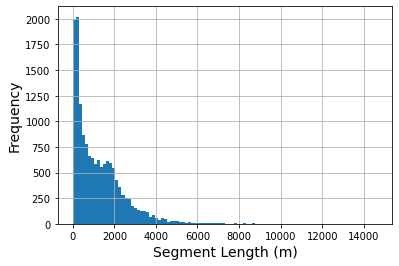

There are 8028 segments in the supernetwork shorter than the threshold length.
That is 53% of all segments in the supernetwork!


In [4]:
#####################################################################################
# Analyze the distribution of segment lengths in the native NHD Full Res data
#####################################################################################

################################################
# Create a histogram of segment lengths
################################################

data.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)

plt.show()

################################################
# What fraction of segments on the network are
# shorter than specified threshold?
################################################

# specify threshold length
thresh = 1000  # meters

short_segs = len(data[data.Length <= thresh].index)
total_segs = len(data.index)

print(
    "There are %s segments in the supernetwork shorter than the threshold length."
    % (short_segs)
)
print(
    "That is %s%% of all segments in the supernetwork!"
    % round(short_segs / total_segs * 100)
)


In [5]:
#####################################################################################
# Extract network connections
#####################################################################################
# replace downstreams for terminal segments
# for more details on this step, see network-analysis.ipynb
data = nhd_io.replace_downstreams(data, network_data["downstream_col"], 0)

# extract the downstream connections of each segment
connections = nhd_network.extract_connections(data, network_data["downstream_col"])

# reverse the network - extract the upstream connections of each segment
rconn = nhd_network.reverse_network(connections)

print("Network connections extracted")


Network connections extracted


In [6]:
def headwater_connections(connections, rconn):

    """
    Determine which segments are and are not headwaters. 
    Headwaters are defined as segments with no upstream connection, only downstream connections. 
    Non-headwaters are defined as segments with both upstream and downstream connections. 

    Args:
        connections (dict): downstream connections
        rconn (dict): upstream connections

    Returns:
        hw_connections (dict): downstream connections, headwaters only
        non_hw_connections (dict): downstream connections, non headwaters only

    """

    hw = []  # store headwater segments
    non_hw = []  # store non-headwater segments

    for seg in rconn.keys():
        # if there is no upstream connection anda downstream connection, it is a headwater
        if bool(rconn[seg]) == False and bool(connections[seg]) == True:
            hw.append(seg)

        # if there is an upstream connection and a downstream connection, it is a non-headwater (midwater?)
        elif bool(rconn[seg]) == True and bool(connections[seg]) == True:
            non_hw.append(seg)

    # get segment key-value pairs from the connections dictionary
    hw_connections = {key: connections[key] for key in hw}
    non_hw_connections = {key: connections[key] for key in non_hw}

    return hw_connections, non_hw_connections


In [7]:
def prune_headwaters(chop, hw_connections, non_hw_connections, data, thresh):

    """
    Prune headwaters from the network
    Headwaters are pruned if they are shorter than the threshold length
    OR if they merge with a midwater that is less than the threshold length

    Args:
        chop (list): A list of pruned headwater indices
        hw_connections (dict): downstream connections, headwaters only
        non_hw_connections (dict): downstream connections, midwaters only
        data (DataFrame): Network to be pruned
        thresh (int): length threshold, segments below this length are slated for pruning

    Returns:
        chop (list): list of pruned headwater indices, updated
        data_pruned (DataFrame): pruned network

    """

    # loop through keys and values in headwater connections dictionary
    for hw_k, srch_v in hw_connections.items():

        """
        Trim headwater-headwater junctions
        
        - Headwater-headwater junctions are junctions where two (or more) headwaters merge. 
        - Once headwater-headwater junctions are identified, the shortest headwater below the
          threshold length is pruned. 
        """

        # create a list of headwaters draining to the specified downstream connections, srch_v
        G = [k for k, v in hw_connections.items() if v == srch_v]

        # if more than one headwater drains into the segment, it is a headwater-headwater junction
        if len(G) > 1:

            # get segment lengths from the test dataset
            hw_len = data.loc[G].Length

            # find the shortest segment
            hw_min_len = hw_len[hw_len.idxmin()]

            # check to see if headwater shorter than threshold length
            if hw_min_len < thresh:

                # update chopping block
                chop.append(hw_len.idxmin())

        ############################################################
        #  Trim headwater-midwater junctions
        ############################################################

        """
        Trim headwater-midwater junctions
        
        - Headwater-midwater junctions are junctions a headwater merges with a non-headwater (i.e. midwater). 
        - If the headwater is shorter than the threshold, it is pruned.
        - If the headwater is longer than the threshold, but joins with or connects to a midwater that is
          shorter than the threshold, the headwater is pruned. 
              - This is done to minimize the number of small midwater segments stranded between headwaters.
                Else, these short, stranded segments cannot be merged upstream or downstream. 
        """

        # midwaters draining into a junction that a headwater does too
        H = [k for k, v in non_hw_connections.items() if v == srch_v]

        # if there is a corresponding midwater, then the headwater is a candidate for trimming
        if bool(H) == True:

            # get segment lengths from the dataset
            hw_len = data.loc[hw_k].Length

            # get midwater (in) length from the test dataset
            mw_in_len = data.loc[H[0]].Length

            # get midwater (out) length from the test dataset
            mw_out_len = data.loc[srch_v[0]].Length

            # check to see if headwater or midwaters (in/out) are shorter than the threshold
            if hw_len < thresh or mw_in_len < thresh or mw_out_len < thresh:

                # update chopping block
                chop.append(hw_k)

    # chop segments from the network
    data_pruned = data.drop(np.unique(chop))

    return np.unique(chop), data_pruned


In [8]:
#####################################################################################
# Prune headwaters
#####################################################################################

# identify headwater and non-headwater (midwater) reaches (that also have a downstream connection)
hw_connections, non_hw_connections = headwater_connections(connections, rconn)

# Prune the network
print("Pruning headwaters...")

pruned_headwaters = []
pruned_headwaters, data_pruned = prune_headwaters(
    pruned_headwaters, hw_connections, non_hw_connections, data, thresh
)

print(
    "Done pruning! Removed",
    len(pruned_headwaters),
    "headwater segments, or",
    int(data.loc[pruned_headwaters].Length.sum() / 1000),
    " river km, from the network.",
)
print(
    "That is",
    int((data.loc[pruned_headwaters].Length.sum() / data.Length.sum()) * 100),
    "% of the total network length!",
)


Pruning headwaters...
Done pruning! Removed 1694 headwater segments, or 3030  river km, from the network.
That is 16 % of the total network length!


In [9]:
#####################################################################################
# Recompute connections and construct reaches from the pruned network data
#####################################################################################

# extract downstream connections for each node
connections_pruned = nhd_network.extract_connections(
    data_pruned, network_data["downstream_col"]
)

# reverse the network - track upstream connections
rconn_pruned = nhd_network.reverse_network(connections_pruned)

# isolate independent subnetworks
subnets = nhd_network.reachable_network(rconn_pruned)

# identify the segments in each subnetwork
subreachable = nhd_network.reachable(rconn_pruned)

# break each subnetwork into reaches
subreaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

print("Network connections extracted and reaches created from pruned network")


Network connections extracted and reaches created from pruned network


In [10]:
#####################################################################################
# Count segments that can be merged in the pruned network
#####################################################################################
counter_segments = 0
counter_segments_orphaned = 0
counter_short_singseg_reaches = 0
counter_short_multiseg_reaches = 0
counter_long_multiseg_partialmerger_reaches = 0

for twi, (tw, rchs) in enumerate(subreaches.items(), 1):

    for rch in rchs:

        rch_len = data_pruned.loc[rch].Length.sum()

        ##################################################
        # orphaned short single segment reaches
        ##################################################
        if rch_len < thresh and len(data_pruned.loc[rch]) == 1:

            counter_short_singseg_reaches += 1
            counter_segments_orphaned += 1

        ##################################################
        # multi segment reaches - combine into a single segment reach
        ##################################################
        if rch_len < thresh and len(data_pruned.loc[rch]) > 1:

            counter_short_multiseg_reaches += 1
            counter_segments += len(rch)

        ##################################################
        # multi segment reaches longer than threshold with some segments shorter than threshold
        ##################################################
        if rch_len > thresh and data_pruned.loc[rch].Length.min() < thresh:

            counter_long_multiseg_partialmerger_reaches += 1
            counter_segments += sum(data_pruned.loc[rch]["Length"] < thresh)
            

print(
    "There are",
    counter_short_singseg_reaches,
    "short single segment reaches that cannot be merged.",
)
print(
    "There are",
    counter_short_multiseg_reaches,
    "short multi-segment reaches that can be completely merged.",
)
print(
    "There are",
    counter_long_multiseg_partialmerger_reaches,
    "long multi-segment reaches that can be partially merged.",
)
print("-------------------------------------------------")
print("We can successfully merge-out", counter_segments, "river segments.")
print(counter_segments_orphaned, "short segments will remain that cannot be merged.")


There are 789 short single segment reaches that cannot be merged.
There are 727 short multi-segment reaches that can be completely merged.
There are 2426 long multi-segment reaches that can be partially merged.
-------------------------------------------------
We can successfully merge-out 6731 river segments.
789 short segments will remain that cannot be merged.


In [11]:
def len_weighted_av(df, var, weight):

    """
    Calculate a weighted average

    Args:
        df (DataFrame): DataFrame containing variables to be averaged and used as weights
        var (str): name of the variable to be averaged
        weight (str): name of the variable to be used as a weight

    Returns:
        x (float32): weighted average

    """

    x = (df[weight] * df[var]).sum() / df[weight].sum()

    return x


In [12]:
def merge_parameters(to_merge):

    """
    length-weighted averaging of channel routing parameters across merged segments

    Args:
        to_merge (DataFrame): DataFrame containing routing parameters for segments to be merged together

    Returns:
        replace (DataFrame): weighted average

    """

    data_replace = to_merge.tail(1)

    idx = to_merge.tail(1).index
    data_replace.loc[idx, "Length"] = to_merge.Length.sum()
    data_replace.loc[idx, "n"] = len_weighted_av(to_merge, "n", "Length")
    data_replace.loc[idx, "nCC"] = len_weighted_av(to_merge, "nCC", "Length")
    data_replace.loc[idx, "So"] = len_weighted_av(to_merge, "So", "Length")
    data_replace.loc[idx, "BtmWdth"] = len_weighted_av(to_merge, "BtmWdth", "Length")
    data_replace.loc[idx, "TopWdth"] = len_weighted_av(to_merge, "TopWdth", "Length")
    data_replace.loc[idx, "TopWdthCC"] = len_weighted_av(
        to_merge, "TopWdthCC", "Length"
    )
    data_replace.loc[idx, "MusK"] = len_weighted_av(to_merge, "MusK", "Length")
    data_replace.loc[idx, "MusX"] = len_weighted_av(to_merge, "MusX", "Length")
    data_replace.loc[idx, "ChSlp"] = len_weighted_av(to_merge, "ChSlp", "Length")

    return data_replace


In [13]:
def correct_reach_connections(data_merged):

    """
    Update downstream connections ("to") for segments in a merged reach.
    Only updates *in-reach* connections.

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections

    """

    for i, idx in enumerate(data_merged.index.values[0:-1]):
        data_merged.loc[idx, "to"] = data_merged.index.values[i + 1]

    return data_merged


In [14]:
def upstream_merge(data_merged, chop):

    """
    Merge a short reach tail segment with upstream neighbor

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach
        chop (list): list of merged-out segments

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # grab the two segments that need to be merged - simply the last two segments of the reach
    to_merge = data_merged.tail(2)

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged
    data_merged = data_merged.drop(to_merge.head(1).index)

    # update "chop" list with merged-out segment IDs
    chop.append(to_merge.head(1).index.values[0])

    return data_merged, chop


In [15]:
def downstream_merge(data_merged, chop, thresh):

    """
    Merge short segments with their downstream neighbors

    Args:
        data_merged (DataFrame): Routing parameters for segments in merged reach
        chop (list): list of merged-out segments
        thresh (int): theshold reach length (meters)

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # find the upstream-most short segment and it's downstream connection
    idx_us = data_merged.loc[data_merged.Length < thresh].head(1).index.values[0]

    pos_idx_us = data_merged.index.get_loc(idx_us)
    idx_to = data_merged.iloc[pos_idx_us + 1].name

    # grab segments to be merged
    to_merge = data_merged.loc[[idx_us, idx_to]]

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged
    data_merged = data_merged.drop(to_merge.head(1).index)

    # update "chop" list with merged-out segment IDs
    chop.append(to_merge.head(1).index.values[0])

    return data_merged, chop


In [16]:
def merge_all(rch, data, chop):

    """
    Merge all segments in a reach

    Args:
        rch (list): Segment indices in the reach to be merged
        data (DataFrame): Routing parameters for network containing the reach to be merged
        chop (list): list of merged-out segments

    Returns:
        data_merged (DataFrame): Routing parameters for segments in merged reach with updated donwstream connections
        chop (list): updated list of merged-out segments

    """

    # subset the model parameter data for this reach
    data_merged = data.loc[rch].copy()

    # grab the two segments that need to be merged - in this case, merge all segments!
    to_merge = data_merged.copy()

    # calculate new parameter values
    data_replace = merge_parameters(to_merge)

    # paste new parameters in to data_merged
    data_merged.loc[to_merge.tail(1).index] = data_replace

    # remove merged segments from data_merged - in this case, all but the last
    data_merged = data_merged.drop(data_merged.iloc[:-1, :].index)

    # update "chop" list with merged-out segment IDs
    chop.extend(list(to_merge.iloc[:-1, :].index))

    return data_merged, chop


In [17]:
def check_length(data, data_merged):

    """
    Check the merged network to the total stream length has not changed.

    Args:
        data (DataFrame): Routing parameters for pre-merged network
        data_merged (DataFrame): Routing parameters for merged reach

    Returns:

    """

    if data.Length.sum() != data_merged.Length.sum():
        print("Error: The merging process has changed the network length")
    else:
        print("Good stuff! The merging process did not change the network length!")


In [18]:
def update_network_data(data, rch, data_merged, chop, rconn):

    """
    Update the network routing parameter data with merged segment data

    Args:
        data (DataFrame): Routing parameters for network to be updated
        rch (list): Segment indices in the reach to be merged
        data_merged (DataFrame): Routing parameters for merged reach

    Returns:
        data (DataFrame): Updated network routing parameters

    """

    # make a copy of the data to be replaced with merged
    data_old = data.loc[rch].copy()

    # drop the segments that disapeared with merger
    data = data.drop(chop)

    # adjust the segment data for those that remain
    data.loc[data_merged.index] = data_merged

    # update out of reach connections - these will change in the first segment was merged out
    upstreams = rconn[
        data_old.head(1).index.values[0]
    ]  # upstream connection of the OLD reach head

    if bool(upstreams):
        data.loc[upstreams, "to"] = data_merged.head(1).index.values[
            0
        ]  # index of NEW reach head

    return data


In [19]:
def check_network(data, data_merged, network_data):

    """
    Check the merged network to ensure subnetwork structure has not changed.

    Args:
        data (DataFrame): Routing parameters for pre-merged network
        data_merged (DataFrame): Routing parameters for merged network
        network_data (dict): supernetwork meta data containing the column name of the downstream connection column

    Returns:

    """

    # extract downstream connections for each node
    connections_merged = nhd_network.extract_connections(
        data_merged, network_data["downstream_col"]
    )
    connections = nhd_network.extract_connections(data, network_data["downstream_col"])

    # reverse the network - track upstream connections
    rconn_merged = nhd_network.reverse_network(connections_merged)
    rconn = nhd_network.reverse_network(connections)

    # isolate independent subnetworks
    subnets_merged = nhd_network.reachable_network(rconn_merged)
    subnets = nhd_network.reachable_network(rconn)

    # compare the number of tailwaters
    if len(subnets_merged.keys()) != len(subnets.keys()):
        print("Error: merging process has changed number of subnetworks!")
    else:
        print("Good stuff! The merging process has preserved the number of subnetworks")
        
    # test network connectivity
    # start at each headwater and trace it down to the tailwater by consecutively finding the "to" segment.
    # if the "to" segment cannot be found, there is a discontinuity in the network
    
    hw_connections, non_hw_connections = headwater_connections(connections_merged, rconn_merged)
    
    print("checking to make sure downstream connections are continuous...")

    pbar = ProgressBar()
    for hw_k in pbar(hw_connections.keys()):
        
        err_flg = 0
        ds_old = hw_k
        ds = int(data_merged.loc[hw_k].to)
        
        while (ds > 0):
            if bool(ds in data_merged.index) == True:
                ds_old = ds
                ds = int(data_merged.loc[ds].to)
            else:
                print("Error: The network is discontinuous!")
                print("Segment",ds_old,"has no downstream connection.")
                print("It should be connected to", ds, ", which doesn't exist in the pruned/merged network.")
                err_flg = 1
                break
                
        if err_flg == 1:
            break
        else:
            continue
            
    if err_flg == 0:      
        print("Done checking connections - pruned/merge network is continuous from headwaters to tailwater(s)")
       

In [20]:
#####################################################################################
# Merge-out short segments
#####################################################################################

# create a copy of the pruned network dataset, which will be updated with merged data
data_pruned_merged = data_pruned.copy()

# initialize list to store merged segment IDs
merged_segments = []

start = time.time()
print("Merging-out short segments, this will take ~2 minutes")

# loop through each reach in the network
for twi, (tw, rchs) in enumerate(subreaches.items(), 1):
    
    for rch in rchs:

        # calculate reach length
        rch_len = data_pruned.loc[rch].Length.sum()

        ##################################################
        # orphaned short single segment reaches
        ##################################################
        # if reach length is shorter than threshold and composed of a single segment
        if rch_len < thresh and len(data_pruned.loc[rch]) == 1:
            continue  # do nothing
            
        ##################################################
        # multi segment reaches - combine into a single segment reach
        ##################################################
        # if reach length is shorter than threshold and composed more than one segment
        if rch_len < thresh and len(data_pruned.loc[rch]) > 1:

            # merge ALL reach segments into one
            chop = []
            data_merged, chop = merge_all(rch, data_pruned, chop)

            # update network with merged data
            data_pruned_merged = update_network_data(
                data_pruned_merged, rch, data_merged, chop, rconn_pruned
            )

            # update merged_segmetns list with merged-out segments
            merged_segments.extend(chop)

        ##################################################
        # multi segment reaches longer than threshold with some segments shorter than threshold
        ##################################################
        # if reach length is longer than threshold and smallest segment length is less than threshold
        if rch_len > thresh and data_pruned.loc[rch].Length.min() < thresh:

            # initialize data_merged - this DataFrame will be subsequently revised
            data_merged = data_pruned.loc[rch]

            # initialize list of segments chopped from this reach
            chop_reach = []

            # so long as the shortest segment is shorter than the threshold...
            while data_merged.Length.min() < thresh:

                # if shortest segment is the last segment in the reach - conduct an upstream merge.
                if (
                    data_merged.Length.idxmin() == data_merged.tail(1).index.values[0]
                    and data_merged.Length.min() < thresh
                ):

                    # upstream merge
                    chop = []
                    data_merged, chop = upstream_merge(data_merged, chop)

                    # update chop_reach list with merged-out segments
                    chop_reach.extend(chop)

                # if shortest segment is NOT the last segment in the reach - conduct a downstream merge
                if (
                    data_merged.Length.idxmin() != data_merged.tail(1).index.values[0]
                    and data_merged.Length.min() < thresh
                ):

                    # downstream merge
                    chop = []
                    data_merged, chop = downstream_merge(data_merged, chop, thresh)

                    # update chop_reach list with merged-out segments
                    chop_reach.extend(chop)
            
            # correct segment connections within reach
            data_merged = correct_reach_connections(data_merged)

            # update the greater network data set
            data_pruned_merged = update_network_data(
                data_pruned_merged, rch, data_merged, chop_reach, rconn_pruned
            )
            
            # update merged_segmetns list with merged-out segments
            merged_segments.extend(chop_reach)


end = time.time()
print("The merging process took", (end - start) / 60, "minutes to complete")

print("Running a few tests to check results...")

# check that the merging process does not change the length of the network
check_length(data_pruned, data_pruned_merged)

# check that the merging process does not change the number of tailwaters in the supernetwork
check_network(data_pruned, data_pruned_merged, network_data)


Merging-out short segments, this will take ~2 minutes


The merging process took 1.3574505885442099 minutes to complete
Running a few tests to check results...
Good stuff! The merging process did not change the network length!
Good stuff! The merging process has preserved the number of subnetworks
checking to make sure downstream connections are continuous...


Done checking connections - pruned/merge network is continuous from headwaters to tailwater(s)


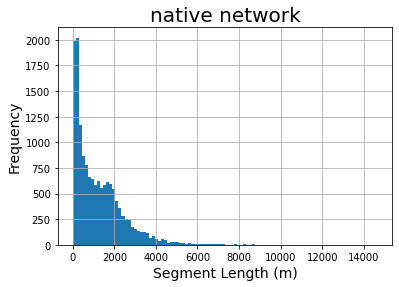

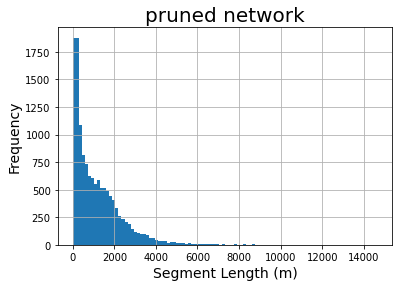

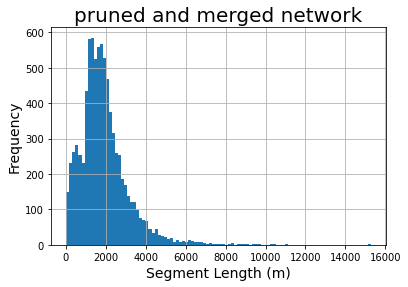

In [21]:
#####################################################################################
# How did pruning and merging change the distribution of segment lengths?
#####################################################################################

##################################################
data.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.title("native network", fontsize=20)

plt.show()

##################################################
data_pruned.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.title("pruned network", fontsize=20)

plt.show()

##################################################
data_pruned_merged.Length.hist(bins=100)

ax = plt.gca()
ax.set_ylabel("Frequency", size=14)
ax.set_xlabel("Segment Length (m)", size=14)
plt.title("pruned and merged network", fontsize=20)

plt.show()


In [22]:
#####################################################################################
# Create qlat destination dictionary to track where the lateral inflows from pruned/merge reaches need to go
# pruned/merged segment: qlat destination
#####################################################################################
merged_pruned_segments = merged_segments + list(pruned_headwaters)

# initialize a library to store qlat desinations for pruned/merged segments
qlat_destinations = {x: {} for x in merged_pruned_segments}

for idx in merged_pruned_segments:
    
    # get the downstream connection of this segment in the original network
    ds_idx = connections[idx]
    
    # find the nearest downstream segment remaining in the pruned/merged network 
    while bool(ds_idx[0] in data_pruned_merged.index) == False:
        ds_idx = connections[ds_idx[0]]
    
    # update the qlat destination dict
    qlat_destinations[idx] = ds_idx
        